In [9]:
# Import built-in libraries
import os
from os.path import abspath

# Import external libraries
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Import internal libraries
from src.plot_confusion_matrix import plot_confusion_matrix

In [10]:
# Load all data
demo = pd.read_csv(abspath("../data/T_demo.csv"))
stage = pd.read_csv(abspath("../data/T_stage.csv"))

# Biomarkers
cre = pd.read_csv(abspath("../data/T_creatinine.csv"))
dbp = pd.read_csv(abspath("../data/T_DBP.csv"))
sbp = pd.read_csv(abspath("../data/T_SBP.csv"))
hgb = pd.read_csv(abspath("../data/T_HGB.csv"))
glu = pd.read_csv(abspath("../data/T_glucose.csv"))
ldl = pd.read_csv(abspath("../data/T_ldl.csv"))

# Medication
meds = pd.read_csv(abspath("../data/T_meds.csv"))

In [11]:
# Group values by patient id
# Calculate the difference between the latest and first measurement for all biomarkers
cre_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in cre.groupby("id")}, name="cre")
dbp_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in dbp.groupby("id")}, name="dbp")
sbp_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in sbp.groupby("id")}, name="sbp")
hgb_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in hgb.groupby("id")}, name="hgb")
glu_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in glu.groupby("id")}, name="glu")
ldl_s = pd.Series({i:(data.iloc[-1]-data.iloc[0]).value for i, data in ldl.groupby("id")}, name="ldl")


# Create a new data frame with the differences
biomarkers_diff = pd.concat([demo, cre_s, dbp_s, sbp_s, hgb_s, glu_s, ldl_s], axis=1)

In [12]:
# Binarize medication labels
# First let's create a dataframe with drugs as columns
meds_bin = pd.DataFrame()

# Iterate over the medications table grouping it by drug
for i,data in meds.groupby("drug"):
    
    # Create an empty array
    drug = np.zeros(demo.id.shape, dtype=bool)
    
    # For each drug, get the patients that are taking it
    # Change the value of the array to true only for the patients takin the drug
    drug[data.id.unique()]=True
    
    # Add a column for the specific drug to the binarized meds dataframe
    meds_bin[i]=drug

meds_bin

,atenolol,atorvastatin,bisoprolol,canagliflozin,carvedilol,dapagliflozin,irbesartan,labetalol,losartan,lovastatin,...,metoprolol,nebivolol,olmesartan,pitavastatin,pravastatin,propranolol,rosuvastatin,simvastatin,telmisartan,valsartan
0,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
296,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
297,False,False,False,False,False,False,True,False,False,False,...,True,False,False,True,False,False,False,False,False,True
298,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [39]:
# Now let's merge together the biomarkers_diff dataframe
# and the meds_bin dataframe
predictors = pd.concat([biomarkers_diff.drop(["id", "race", "gender"], axis=1),
                        meds_bin, stage.drop("id", axis=1)], axis=1)

# Divide predictors for Stage_Progress
predictors_false = predictors[predictors.Stage_Progress == False]
predictors_true = predictors[predictors.Stage_Progress == True]

In [40]:
# Get a balanced test set for Stage Progress
false_train, false_test = train_test_split(predictors_false, test_size=15)
true_train, true_test = train_test_split(predictors_true, test_size=15)

# Concat test and train
train = pd.concat([false_train, true_train])
test = pd.concat([false_test, true_test])

In [41]:
%%time
# Train a random forest 
model = RandomForestClassifier(bootstrap=True, n_estimators=10000, n_jobs=-1)
model.fit(train.drop("Stage_Progress", axis=1), train.Stage_Progress.values.ravel())

CPU times: user 31.2 s, sys: 9.6 s, total: 40.8 s
Wall time: 25.3 s


RandomForestClassifier(n_estimators=10000, n_jobs=-1)

In [42]:
model.score(test.drop("Stage_Progress", axis=1), test.Stage_Progress)

0.7333333333333333

In [43]:
predicted = model.predict(test.drop("Stage_Progress", axis=1))

In [44]:
cm = confusion_matrix(test.Stage_Progress, predicted)

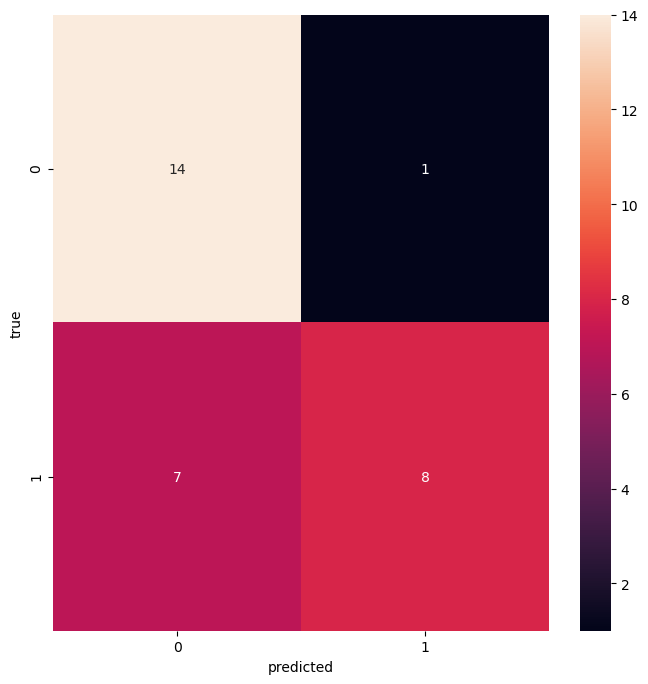

In [45]:
plot_confusion_matrix(cm)
plt.show()